<a href="https://colab.research.google.com/github/maro-amoeba/Osashimi_Tengoku/blob/master/Keras_MNIST_TensorBoard.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# データセットの読み込み

今回はMNISTを用意します  
参考  
https://github.com/keras-team/keras/blob/master/examples/tensorboard_embeddings_mnist.py

In [1]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

import keras
from keras.datasets import mnist
from keras import backend as K

num_classes = 10
img_rows, img_cols = 28, 28


# 訓練データとテストデータに分割
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# sprite用
x_sprite = x_test

# データのフォーマットを確認
if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

# [0-255]の値を[0.0-1.0]に変換
x_train = x_train.astype('float32') / 255 
x_test = x_test.astype('float32') / 255

# クラスごとのone-hot表現に変換
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

Using TensorFlow backend.


11493376/11490434 [==============================] - 1s 0us/step
x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


# TensorBoardの準備

## Google Colab内でTensorBoardを実行する 

参考:[Quick guide to run TensorBoard in Google Colab](https://www.dlology.com/blog/quick-guide-to-run-tensorboard-in-google-colab/)

In [2]:
# ngrokのインストール
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip ngrok-stable-linux-amd64.zip

# TensorBoardのlogフォルダ
LOG_DIR = './log'
if not os.path.exists(LOG_DIR):
    os.makedirs(LOG_DIR)

# TensorBoardをバックグラウンドで実行
LOG_DIR = './log'
get_ipython().system_raw(
    'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'
    .format(LOG_DIR))

# ngrokバックグラウンドプロセスを起動
# TensorBoardのポート6006を開放します。
get_ipython().system_raw('./ngrok http 6006 &')

--2018-11-15 11:51:22--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 52.3.63.2, 52.22.34.127, 52.22.236.254, ...
Connecting to bin.equinox.io (bin.equinox.io)|52.3.63.2|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5363700 (5.1M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip’

ngrok-stable-linux- 100%[===================>]   5.11M  9.52MB/s    in 0.5s    

2018-11-15 11:51:23 (9.52 MB/s) - ‘ngrok-stable-linux-amd64.zip’ saved [5363700/5363700]

Archive:  ngrok-stable-linux-amd64.zip
  inflating: ngrok                   


In [3]:
# TensorBoard表示のURLを取得
!curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

http://e00fbdad.ngrok.io


## PROJECTORの準備

識別などで潜在空間が適切に識別できる空間になっているかを可視化して確認したい場合利用します。  
参考:  
[可視化メモ](https://qiita.com/gabdro/items/84bcf610533a649f7957)  
[【TensorBoard入門:Projector編】TensorFlow処理をかっこよく見える化](https://qiita.com/FukuharaYohei/items/70f702ee85e23b5b1e26)

In [0]:
# http://www.pinchofintelligence.com/simple-introduction-to-tensorboard-embedding-visualisation/

def create_sprite_image(images):
    """Returns a sprite image consisting of images passed as argument. Images should be count x width x height"""
    # MNISTは28ピクセル四方 
    img_h = images.shape[1]
    img_w = images.shape[2]

    # 画像数の平方根(切上)を計算(Sprite Imageの1辺の長さに使用)
    n_plots = int(np.ceil(np.sqrt(images.shape[0])))

    # 全要素0の配列作成
    spriteimage = np.ones((img_h * n_plots ,img_w * n_plots ))

    for i in range(n_plots):
        for j in range(n_plots):
            this_filter = i * n_plots + j

            # 画像がある限り実行(n_plotsが割り切れないためSprite Imageは少し余る)
            if this_filter < images.shape[0]:

                # Sprite Imageの所定の配列に画像を挿入
                spriteimage[i * img_h:(i + 1) * img_h, j * img_w:(j + 1) * img_w] = images[this_filter]

    return spriteimage

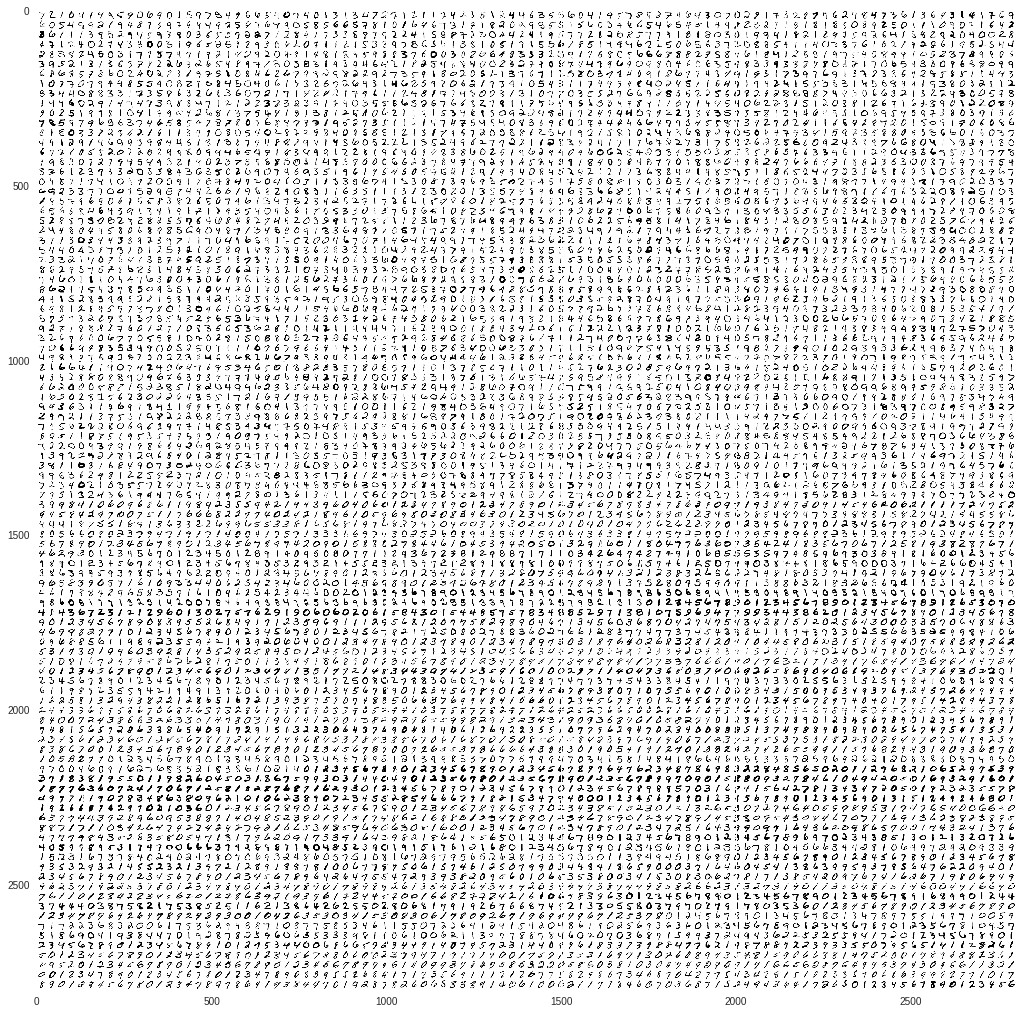

In [5]:
# Sprite Image生成
sprite_image = create_sprite_image(x_sprite)

# Sprite Image表示
plt.figure(figsize=(18,18))
plt.imshow(sprite_image)

# Sprite Image保存
plt.imsave(os.path.join(LOG_DIR, 'sprites.png'), sprite_image, cmap='gray')

In [6]:
# メタデータ作成・保存
with open(os.path.join(LOG_DIR, 'metadata.tsv'), 'w') as f:
    f.write("Index\tLabel\n")
    for index,label in enumerate(np.where(y_test)[1]):
        f.write("%d\t%d\n" % (index,label))

# メタデータのチェック
!head log/metadata.tsv

Index	Label
0	7
1	2
2	1
3	0
4	4
5	1
6	4
7	9
8	5


# KerasのCNNモデルを実行

## CNNモデル構築

In [7]:
from keras.models import Model
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import Adam
from keras.callbacks import TensorBoard

# 畳み込みニューラルネットワークを構築
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

# モデルの要約を表示
model.summary()

# モデルのコンパイル
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=0.001, epsilon=1e-8, decay=1e-4),
              metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 12, 12, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 9216)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               1179776   
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
__________

## モデルの学習

In [8]:
batch_size = 128
epochs = 5

# 訓練中に適応するコールバックを作成
# https://keras.io/ja/callbacks/#tensorboard
tb = TensorBoard(log_dir=LOG_DIR, histogram_freq=1, batch_size=batch_size, 
                                       write_graph=True, write_grads=True, write_images=True)

# モデルの訓練
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(x_test, y_test),
                    callbacks=[tb])

Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 12s 193us/step - loss: 0.2443 - acc: 0.9267 - val_loss: 0.0514 - val_acc: 0.9830
Epoch 2/5
60000/60000 [==============================] - 9s 146us/step - loss: 0.0859 - acc: 0.9750 - val_loss: 0.0365 - val_acc: 0.9875
Epoch 3/5
60000/60000 [==============================] - 9s 147us/step - loss: 0.0627 - acc: 0.9812 - val_loss: 0.0320 - val_acc: 0.9902
Epoch 4/5
60000/60000 [==============================] - 9s 146us/step - loss: 0.0500 - acc: 0.9846 - val_loss: 0.0335 - val_acc: 0.9883
Epoch 5/5
60000/60000 [==============================] - 9s 147us/step - loss: 0.0424 - acc: 0.9873 - val_loss: 0.0303 - val_acc: 0.9902


## モデルの評価

Test loss: 0.03033269578544714
Test accuracy: 0.9902


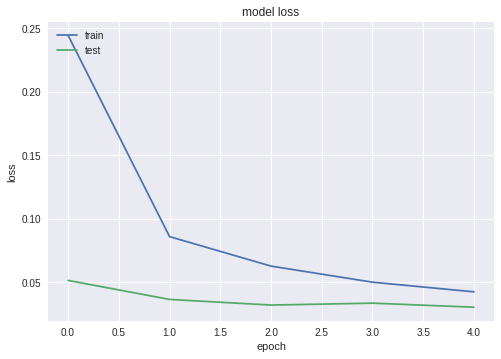

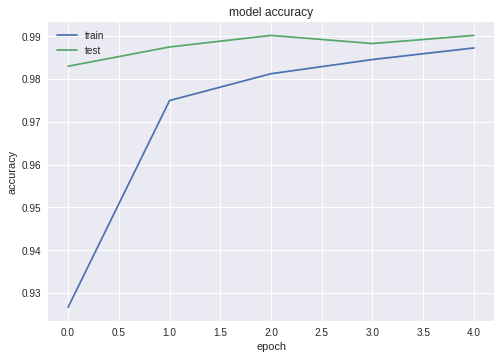

In [9]:
# 損失値と正解率を取得
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

# 損失値をグラフ表示
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# 正解率をグラフ表示
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## PROJECTORの生成

In [10]:
import tensorflow as tf
from tensorflow.contrib.tensorboard.plugins import projector
from keras.models import Model

res = Model(inputs=model.input,
                     outputs=model.get_layer('dense_1').output)
emb = res.predict(x_test)

# embeddingsの作成
embedding_var = tf.Variable(emb,  name='mnist_embedding')

# TensorBoardに書き込む前準備
writer = tf.summary.FileWriter(LOG_DIR)

# Projector設定
config = projector.ProjectorConfig()
embedding = config.embeddings.add()
embedding.tensor_name = embedding_var.name

# メタデータ(CSV)パス
embedding.metadata_path='metadata.tsv'

# Sprite Imageパスと設定
embedding.sprite.image_path='sprites.png'
embedding.sprite.single_image_dim.extend([28,28])

# Projectorに出力
projector.visualize_embeddings(writer, config)

# データのセーブ
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())
saver = tf.train.Saver()
saver.save(sess, os.path.join(LOG_DIR,'model.ckpt'),1)

'./log/model.ckpt-1'

TensorBoardのURLへアクセス、または更新などをして  
メニューからPROJECTORを見れます

epoch数を増やしたりして遊びましょう！